In [1]:
# import data
from datetime import datetime
begin = datetime.now()
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv/train.csv')
train = pd.DataFrame(train)
# data=data.dropna(subset=['title','text'])
train['title'] = train['title'].astype("string")
train["text"] = train["text"].astype("string")
train["author"] = train["author"].astype("string")

train=train.fillna(' ')
# check data
print(train.shape)
train.head(10)

train.drop('author', axis = 1, inplace= True)

#making dictionary {id:text}
text_dict = {}
for i in train.id:
    text_dict[i] = train.text[i] #using text 


starwars_episodes =text_dict

(20800, 5)


In [2]:
print(train.shape)
print(train.head(5))

(20800, 4)
   id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print 
An Iranian woman has been sentenced to ...      1  


# LDA


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud

def display_topic(words_probabilities):
    bows = []
    [bows.extend([word] * (int(probability*100) + 1)) for word,probability in words_probabilities]
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(' '.join(bows))
    plt.figure(figsize=[3,3])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [4]:
n_topics = 5

In [5]:
import gensim
docs = [[token.lower() for token in gensim.utils.tokenize(gensim.parsing.preprocessing.remove_stopwords(doc))] for doc in starwars_episodes.values()]
vocab = gensim.corpora.Dictionary(docs)
bow_corpus = [vocab.doc2bow(doc) for doc in docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = n_topics, id2word = vocab, passes = 10, workers = 2)

In [6]:
all_topics = lda_model.get_document_topics(bow_corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [7]:
all_topics_df

,0,1,2,3,4
0,0.248891,0.000425,0.749842,0.000426,0.000417
1,0.098984,0.000550,0.695024,0.204905,0.000537
2,0.548927,0.040569,0.409936,0.000287,0.000281
3,0.906194,0.023575,0.000673,0.068897,0.000660
4,0.475192,0.002491,0.077013,0.442824,0.002480
...,...,...,...,...,...
20795,0.061002,0.001043,0.678715,0.258214,0.001027
20796,0.000340,0.000339,0.000339,0.998649,0.000333
20797,0.000423,0.536638,0.000420,0.462107,0.000413
20798,0.995354,0.001168,0.001161,0.001170,0.001146


In [8]:
lda_model.show_topic(2)

[('i', 0.01949073),
 ('s', 0.018649958),
 ('t', 0.010315183),
 ('it', 0.010113428),
 ('the', 0.009229711),
 ('clinton', 0.00835975),
 ('trump', 0.006888658),
 ('people', 0.0059810816),
 ('you', 0.00530397),
 ('hillary', 0.005278562)]

In [9]:
lda_model.print_topics()

[(0,
  '0.022*"s" + 0.015*"mr" + 0.014*"trump" + 0.012*"the" + 0.012*"said" + 0.007*"president" + 0.005*"state" + 0.004*"obama" + 0.004*"government" + 0.004*"in"'),
 (1,
  '0.016*"s" + 0.014*"the" + 0.005*"percent" + 0.005*"it" + 0.004*"new" + 0.004*"said" + 0.004*"in" + 0.004*"people" + 0.003*"year" + 0.003*"company"'),
 (2,
  '0.019*"i" + 0.019*"s" + 0.010*"t" + 0.010*"it" + 0.009*"the" + 0.008*"clinton" + 0.007*"trump" + 0.006*"people" + 0.005*"you" + 0.005*"hillary"'),
 (3,
  '0.021*"s" + 0.016*"said" + 0.013*"the" + 0.010*"i" + 0.010*"mr" + 0.006*"it" + 0.005*"he" + 0.005*"ms" + 0.004*"new" + 0.004*"a"'),
 (4,
  '0.015*"la" + 0.012*"в" + 0.010*"и" + 0.010*"en" + 0.009*"el" + 0.008*"que" + 0.007*"y" + 0.005*"на" + 0.005*"что" + 0.005*"los"')]

In [10]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = " ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7499,i s t it the clinton trump people you hillary,"[house, dem, aide, we, didn, t, even, see, com..."
1,1,2.0,0.6950,i s t it the clinton trump people you hillary,"[ever, feeling, life, circles, roundabout, hea..."
2,2,0.0,0.5489,s mr trump the said president state obama gove...,"[why, truth, might, get, you, fired, october, ..."
3,3,0.0,0.9062,s mr trump the said president state obama gove...,"[videos, civilians, killed, in, single, us, ai..."
4,4,0.0,0.4749,s mr trump the said president state obama gove...,"[print, an, iranian, woman, sentenced, years, ..."
5,5,2.0,0.8485,i s t it the clinton trump people you hillary,"[in, trying, times, jackie, mason, voice, reas..."
6,6,3.0,0.9328,s said the i mr it he ms new a,"[ever, wonder, britain, s, iconic, pop, pianis..."
7,7,0.0,0.4761,s mr trump the said president state obama gove...,"[paris, france, chose, idealistic, traditional..."
8,8,2.0,0.3988,i s t it the clinton trump people you hillary,"[donald, j, trump, scheduled, highly, anticipa..."
9,9,0.0,0.8920,s mr trump the said president state obama gove...,"[a, week, michael, t, flynn, resigned, nationa..."


In [11]:
df_dominant_topic.shape

(20800, 5)

In [12]:
df_dominant_topic.to_csv('lda_train_text_5.csv', index=False)

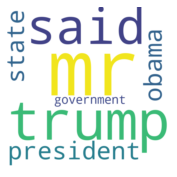

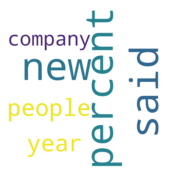

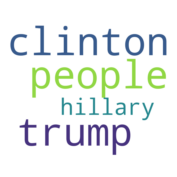

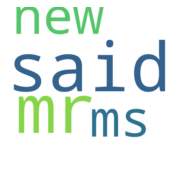

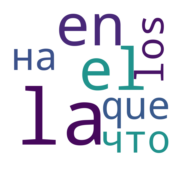

In [13]:
for topic_no in range(n_topics):
    display_topic(lda_model.show_topic(topic_no))

# Clustering

In [14]:
# from scipy.spatial.distance import cosine
# from mpl_toolkits.mplot3d import axes3d, Axes3D 
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.decomposition import PCA
# import pandas as pd
# import seaborn as sns
# import numpy as np

# def k_cluster(vectors, k):
#     clusterer = KMeans(n_clusters = k)
#     clusterer.fit(vectors)
#     return clusterer.labels_

# def d_cluster(vectors):
#   clusterer = DBSCAN(eps=20, min_samples=3)
#   clusterer.fit(vectors)
#   return clusterer.labels_

# def plot_clusters(words, svectors, clusters):
#   pca = PCA(n_components=3)
#   principalComponents = pca.fit_transform(svectors)
  
#   dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])

#   sns.set_style("whitegrid")
#   palette = sns.color_palette("husl", max(set(clusters))+1) + ['grey']
#   dataframe['colour'] = pd.Series([palette[i] for i in clusters])
  
#   fig = plt.figure()
#   graph = Axes3D(fig)
#   [graph.text(x, z, y, s, 'x', color = c) for x, y, z, s, c in zip(dataframe['x'], dataframe['y'], dataframe['z'], words, dataframe['colour'])]
#   graph.set_xlim(min(dataframe['x']), max(dataframe['x']))
#   graph.set_ylim(min(dataframe['z']), max(dataframe['z']))
#   graph.set_zlim(min(dataframe['y']), max(dataframe['y']))
#   plt.show()
  
#   graph2=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
#   [graph2.text(x, y, s,color=c) for x,y,s,c in zip(dataframe['x'],dataframe['y'],words,dataframe["colour"])]

# def cluster_centre(cluster_vectors):
#   return np.mean( np.array(cluster_vectors), axis=0 )
  
# def name_cluster(cluster_words, cluster_vectors):
#   cc_vector = cluster_centre(cluster_vectors)
#   vector_distances = [cosine(vector,cc_vector) for vector in cluster_vectors]
#   return cluster_words[np.argmin(vector_distances)]

convert words to vectors (e.g. spacy - feel free to use others)

In [15]:
# import spacy
# sp =  spacy.load('en')
# sp_text = sp('\n'.join(starwars_episodes.values()).lower())
# sp_words = [word.text for word in sp_text if word.is_alpha and not word.is_stop]
# sp_vectors = [word.vector for word in sp_text if word.is_alpha and not word.is_stop]

## K-Means
cluster the word vectors using k-means clustering (number of clusters are determined by you)

In [16]:
# clusterer_labels = k_cluster(sp_vectors, n_topics)

In [17]:
# plot_clusters(sp_words, sp_vectors, clusterer_labels)

In [18]:
# clusters = {i:[] for i in set(clusterer_labels)}
# for idx,cluster_number in enumerate(clusterer_labels):
#     clusters[cluster_number].append(idx)

# [f"{cluster_no}:{name_cluster([sp_words[i] for i in cluster_ids], [sp_vectors[i] for i in cluster_ids])}" for cluster_no,cluster_ids in clusters.items() if cluster_no > -1]

In [19]:
# for cluster_number,cluster_ids in clusters.items():
#     if cluster_number > -1:
#         cluster_words = [sp_words[i] for i in cluster_ids] 
#         cluster_vectors = [sp_vectors[i] for i in cluster_ids]

#         cluster_name = name_cluster(cluster_words, cluster_vectors)
#         cluster_words += [f'{cluster_number}:{cluster_name.upper()}']

#         cc_vector = cluster_centre(cluster_vectors)
#         cluster_vectors.append(cc_vector)

#         cluster_colour = [cluster_number]*len(cluster_ids) +  [cluster_number - 1]

#     plot_clusters(cluster_words, cluster_vectors, cluster_colour)

## DBScan
cluster the word vectors using a density based algorithm (number of clusters are automatically determined by the algorithm)

In [20]:
# clusterer_labels = d_cluster(sp_vectors)
# len(set(clusterer_labels))

In [21]:
# plot_clusters(sp_words, sp_vectors, clusterer_labels)

In [22]:
# clusters = {i:[] for i in set(clusterer_labels)}
# for idx,cluster_number in enumerate(clusterer_labels):
#     clusters[cluster_number].append(idx)

# [f"{cluster_no}:{name_cluster([sp_words[i] for i in cluster_ids], [sp_vectors[i] for i in cluster_ids])}" for cluster_no,cluster_ids in clusters.items() if cluster_no > -1]

In [23]:
# for cluster_number,cluster_ids in clusters.items():
#     if cluster_number > -1:
#         cluster_words = [sp_words[i] for i in cluster_ids] 
#         cluster_vectors = [sp_vectors[i] for i in cluster_ids]

#         cluster_name = name_cluster(cluster_words, cluster_vectors)
#         cluster_words += [f'{cluster_number}:{cluster_name.upper()}']

#         cc_vector = cluster_centre(cluster_vectors)
#         cluster_vectors.append(cc_vector)

#         cluster_colour = [cluster_number]*len(cluster_ids) +  [cluster_number - 1]

#         plot_clusters(cluster_words, cluster_vectors, cluster_colour)